In [1]:
!pip install torchmetrics -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 840.2/840.2 kB 11.3 MB/s eta 0:00:00


In [2]:
import torch
from PIL import Image
import os
import random
import shutil
from tqdm import tqdm
from PIL import Image, ImageDraw
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch.utils.data import TensorDataset, DataLoader, Dataset

random.seed(108)

## download data

In [3]:
!mkdir data
!cd data && curl -L "https://universe.roboflow.com/ds/SqM5alVcwM?key=kGWvc551LX" > roboflow.zip; unzip roboflow.zip; rm roboflow.zip

Streaming output truncated to the last 5000 lines.
 extracting: train/labels/M_I_mov-45_jpg.rf.f7f7f2957d8fa5baed277731bbd14fe6.txt  
 extracting: train/labels/M_I_mov-46_jpg.rf.ee021b0920f5eb492a01c05c763279a9.txt  
 extracting: train/labels/M_I_mov-47_jpg.rf.408fd6178f8735f2dfb688e18d9fd285.txt  
 extracting: train/labels/M_I_mov-48_jpg.rf.82cb853cd7b2edc4e4d181ded072a093.txt  
 extracting: train/labels/M_I_mov-49_jpg.rf.55f6b4344ff28618a06880de6c2270eb.txt  
 extracting: train/labels/M_I_mov-50_jpg.rf.ba3b35ad3ab1000f1c067967da601558.txt  
 extracting: train/labels/M_I_mov-52_jpg.rf.fb4b940e46c80cc0b7971f5b9a8c4ce9.txt  
 extracting: train/labels/M_I_mov-53_jpg.rf.98020a93298052786eb1eb6c2e1f70c1.txt  
 extracting: train/labels/M_I_mov-54_jpg.rf.79847d9b758f848d81875091c528a28c.txt  
 extracting: train/labels/M_I_mov-56_jpg.rf.1acefaead8351b58934ae694e7ecbd99.txt  
 extracting: train/labels/M_I_mov-6_jpg.rf.ebc294976cba8a85073f7e88ed4a405b.txt  
 extracting: train/labels/M_I_mov-8_j

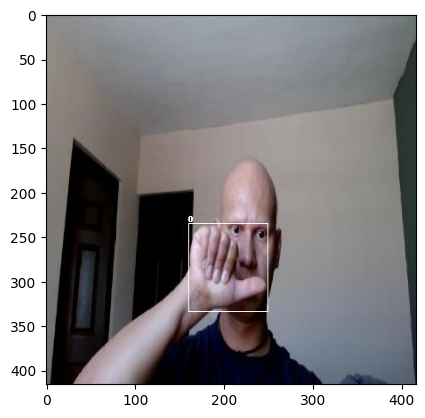

In [4]:
random.seed(0)

def plot_bounding_box(image, annotation_list):
    annotations = np.array(annotation_list)
    w, h = image.size

    plotted_image = ImageDraw.Draw(image)

    transformed_annotations = np.copy(annotations)
    transformed_annotations[:,[1,3]] = annotations[:,[1,3]] * w
    transformed_annotations[:,[2,4]] = annotations[:,[2,4]] * h

    transformed_annotations[:,1] = transformed_annotations[:,1] - (transformed_annotations[:,3] / 2)
    transformed_annotations[:,2] = transformed_annotations[:,2] - (transformed_annotations[:,4] / 2)
    transformed_annotations[:,3] = transformed_annotations[:,1] + transformed_annotations[:,3]
    transformed_annotations[:,4] = transformed_annotations[:,2] + transformed_annotations[:,4]

    for ann in transformed_annotations:
        obj_cls, x0, y0, x1, y1 = ann
        plotted_image.rectangle(((x0,y0), (x1,y1)))

        plotted_image.text((x0, y0 - 10), str(int(obj_cls)))
        crop_image = np.array(image)
        crop_image  = crop_image[int(y0):int(y1),int(x0):int(x1),:]

    plt.imshow(np.array(image))
    plt.show()
    return crop_image

# Get any random annotation file
#annotation_file = random.choice(annotations)

root_annotation = 'data/test/labels/'
root_image = 'data/test/images/'

annotation_file = 'A-D_mp4-13_jpg.rf.c5ce963305f4e20f80718069509faed7.txt'
with open(root_annotation + annotation_file, "r") as file:
    annotation_list = file.read().split()
    annotation_list = [[float(x) for x in annotation_list]]

#Get the corresponding image file
image_file = root_image + annotation_file.replace("annotations", "images").replace("txt", "jpg")
assert os.path.exists(image_file)

#Load the image
image = Image.open(image_file)

#Plot the Bounding Box
crop_image = plot_bounding_box(image, annotation_list)

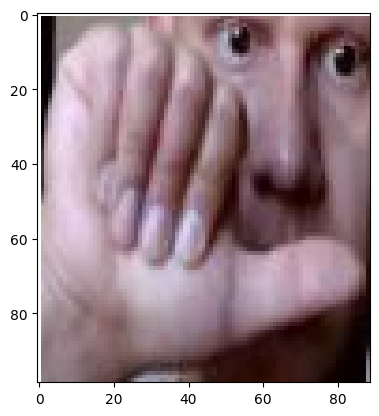

In [5]:
plt.imshow(crop_image)

In [6]:
def crop_hand_image(image, annotation_list):
    annotations = np.array(annotation_list)
    w, h = image.size

    transformed_annotations = np.copy(annotations)
    transformed_annotations[:,[1,3]] = annotations[:,[1,3]] * w
    transformed_annotations[:,[2,4]] = annotations[:,[2,4]] * h

    transformed_annotations[:,1] = transformed_annotations[:,1] - (transformed_annotations[:,3] / 2)
    transformed_annotations[:,2] = transformed_annotations[:,2] - (transformed_annotations[:,4] / 2)
    transformed_annotations[:,3] = transformed_annotations[:,1] + transformed_annotations[:,3]
    transformed_annotations[:,4] = transformed_annotations[:,2] + transformed_annotations[:,4]

    for ann in transformed_annotations:
        obj_cls, x0, y0, x1, y1 = ann

        crop_image = np.array(image)
        crop_image  = crop_image[int(y0):int(y1),int(x0):int(x1),:]

    return crop_image, int(obj_cls)

def crop_hand_all():
    data_folders = {'data/train/', 'data/test/', 'data/valid/'}
    crop_folder = 'data/cropped/'

    if not os.path.exists(crop_folder):
        os.makedirs(crop_folder)

    # paths = []
    # classes = []
    # subsets = []

    for data_folder in data_folders:

        if 'train' in data_folder:
            subset = 'train'
        elif 'test' in data_folder:
            subset = 'test'
        else:
            subset = 'valid'

        if not os.path.exists(crop_folder + subset):
            os.makedirs(crop_folder + subset)

        for annotation_path in os.listdir(data_folder + 'labels'):
            root_annotation = data_folder + 'labels/'
            root_image = data_folder + 'images/'

            with open(root_annotation + annotation_path, "r") as file:
                annotation_list = file.read().split("\n")[0].split()
                annotation_list = [[float(x) for x in annotation_list]]

            #Get the corresponding image file
            image_name = annotation_path.replace("annotations", "images").replace("txt", "jpg")
            image_abs_path = root_image + image_name
            assert os.path.exists(image_abs_path)
            #print(image_abs_path)
            image = Image.open(image_abs_path)

            crop_image, obj_cls = crop_hand_image(image, annotation_list)

            if not os.path.exists(crop_folder + subset + '/' + str(obj_cls)):
                os.makedirs(crop_folder + subset + '/' + str(obj_cls))

            crop_image_path = crop_folder + subset + '/' + str(obj_cls) + '/' + image_name
            Image.fromarray(crop_image).resize((255, 255)).save(crop_image_path, 'JPEG')

    #         paths.append(crop_image_path)
    #         classes.append(obj_cls)
    #         subsets.append(subset)

    # return pd.DataFrame({'path': paths, 'class': classes, 'subset': subsets})

data_df = crop_hand_all()

## data transform & loader

In [7]:
bs = 64
crop_size = 255

train_transform = transforms.Compose([
    transforms.RandomRotation(10),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

test_transform = transforms.Compose([
    transforms.Resize(255),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

train_set = datasets.ImageFolder("data/cropped/train", transform=train_transform)
trainloader = DataLoader(train_set, batch_size=bs, shuffle=True, num_workers=2)

val_set = datasets.ImageFolder("data/cropped/valid", transform=test_transform)
valloader = DataLoader(val_set, batch_size=bs, shuffle=True)

test_set = datasets.ImageFolder("data/cropped/test", transform=test_transform)
testloader = DataLoader(test_set, shuffle=True)

In [8]:
len(train_set), len(val_set), len(test_set)

(6928, 840, 965)

In [9]:
train_set.classes, len(train_set.classes)

(['0',
  '1',
  '10',
  '11',
  '12',
  '13',
  '14',
  '15',
  '16',
  '17',
  '18',
  '19',
  '2',
  '20',
  '3',
  '4',
  '5',
  '6',
  '7',
  '8',
  '9'],
 21)

In [10]:
feature, target = next(iter(trainloader))
feature.shape

torch.Size([64, 3, 255, 255])

## model

In [51]:
from torchvision.models import mobilenet_v2
from torch import nn, optim

model = mobilenet_v2(pretrained=True)
model.classifier[1] = nn.Linear(model.last_channel, len(train_set.classes))

# Check if GPU is available and move the model to GPU if it is
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Define your loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [62]:
from torchmetrics.classification import MulticlassAccuracy
from torchmetrics.classification import F1Score

def training(trainloader = trainloader, valloader = valloader, num_epochs=10):

    train_acc = MulticlassAccuracy(num_classes=len(train_set.classes), average ='micro').to(device)
    train_acc_per_class = MulticlassAccuracy(num_classes=len(train_set.classes), average =None).to(device)
    train_f1 = F1Score(task='multiclass', num_classes=len(train_set.classes)).to(device)

    val_acc = MulticlassAccuracy(num_classes=len(train_set.classes), average ='micro').to(device)
    val_acc_per_class = MulticlassAccuracy(num_classes=len(train_set.classes), average =None).to(device)
    val_f1 = F1Score(task='multiclass', num_classes=len(train_set.classes)).to(device)

    train_evals = {'acc': [], 'loss':[], 'f1': [], 'acc per class': []}
    val_evals = {'acc': [], 'loss':[], 'f1': [], 'acc per class': []}

    for epoch in range(num_epochs):

        # Train
        model.train()
        for images, labels in tqdm(trainloader):
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            train_acc.update(outputs, labels)
            train_f1.update(outputs, labels)
            train_acc_per_class.update(outputs, labels)

            train_evals['loss'].append(loss.cpu().detach().numpy())
            train_evals['acc'].append(train_acc.compute().cpu().detach().numpy())
            train_evals['f1'].append(train_f1.compute().cpu().detach().numpy())
            train_evals['acc per class'].append(train_acc_per_class.compute().cpu().detach().numpy())

            loss.backward()
            optimizer.step()

        # Validation
        model.eval()
        with torch.no_grad():
            for images, labels in tqdm(valloader):
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                val_loss = criterion(outputs, labels)
                val_acc.update(outputs, labels)
                val_f1.update(outputs, labels)
                val_acc_per_class.update(outputs, labels)

                val_evals['loss'].append(val_loss.cpu().detach().numpy())
                val_evals['acc'].append(val_acc.compute().cpu().detach().numpy())
                val_evals['f1'].append(val_f1.compute().cpu().detach().numpy())
                val_evals['acc per class'].append(val_acc_per_class.compute().cpu().detach().numpy())

        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {loss.item():.4f}, Train Acc: {train_evals["acc"][-1]}, Train F1: {train_evals["f1"][-1]}')
        print(f'Train Acc per Class: {train_evals["acc per class"][-1]}\n')
        print(f'Epoch [{epoch+1}/{num_epochs}], Val Loss {val_loss.item():.4f}, Val Acc: {val_evals["acc"][-1]}, Val F1: {val_evals["f1"][-1]}\n')

In [52]:
training()

100%|██████████| 14/14 [00:03<00:00,  4.38it/s]


Epoch [1/10], Train Loss: 0.5646, Train Acc: 0.7062644362449646, Train F1: 0.7062644362449646
Train Acc per Class: [0.878125   0.8238806  0.6744186  0.69512194 0.84319526 0.7461774
 0.5423198  0.6323987  0.67484665 0.5195195  0.6        0.65178573
 0.6548387  0.66964287 0.6987952  0.7469512  0.5987842  0.7357357
 0.76993865 0.76687115 0.90029323]

Epoch [1/10], Val Loss 0.1755, Val Acc: 0.9678571224212646, Val F1: 0.9678571224212646



100%|██████████| 14/14 [00:03<00:00,  4.42it/s]


Epoch [2/10], Train Loss: 0.1067, Train Acc: 0.8410796523094177, Train F1: 0.8410796523094177
Train Acc per Class: [0.9359375  0.90149254 0.815407   0.82012194 0.91863906 0.8608563
 0.7429467  0.78660434 0.8082822  0.7372372  0.775      0.8110119
 0.82741934 0.8348214  0.8433735  0.8719512  0.7933131  0.8648649
 0.8773006  0.8834356  0.94868034]

Epoch [2/10], Val Loss 0.0495, Val Acc: 0.9779762029647827, Val F1: 0.9779762029647827



100%|██████████| 14/14 [00:03<00:00,  4.43it/s]


Epoch [3/10], Train Loss: 0.0696, Train Acc: 0.8908776044845581, Train F1: 0.8908776044845581
Train Acc per Class: [0.95625    0.93134326 0.875      0.8770325  0.9447732  0.90316004
 0.82758623 0.84527516 0.8599182  0.8198198  0.84313726 0.8700397
 0.8849462  0.88988096 0.8935743  0.91260165 0.8591692  0.9089089
 0.9161554  0.9222904  0.96480936]

Epoch [3/10], Val Loss 0.0323, Val Acc: 0.9841269850730896, Val F1: 0.9841269850730896



100%|██████████| 14/14 [00:04<00:00,  2.88it/s]


Epoch [4/10], Train Loss: 0.0510, Train Acc: 0.9172560572624207, Train F1: 0.9172560572624207
Train Acc per Class: [0.9671875  0.9485075  0.90552324 0.9077744  0.9585799  0.9266055
 0.86912227 0.87772584 0.88957053 0.8641141  0.88161767 0.9010417
 0.9137097  0.91741073 0.92018074 0.9344512  0.89361703 0.9316817
 0.93711656 0.94095093 0.97360706]

Epoch [4/10], Val Loss 0.1702, Val Acc: 0.9857142567634583, Val F1: 0.9857142567634583



100%|██████████| 14/14 [00:03<00:00,  3.63it/s]


Epoch [5/10], Train Loss: 0.0140, Train Acc: 0.9334295392036438, Train F1: 0.9334295392036438
Train Acc per Class: [0.97375    0.958806   0.9238372  0.92560977 0.96686393 0.9412844
 0.89467084 0.8996885  0.9110429  0.8912913  0.9047059  0.9202381
 0.93096775 0.93392855 0.9361446  0.94756097 0.9136778  0.94534534
 0.94969326 0.95214725 0.97888565]

Epoch [5/10], Val Loss 0.0055, Val Acc: 0.9878571629524231, Val F1: 0.9878571629524231



100%|██████████| 14/14 [00:03<00:00,  3.54it/s]


Epoch [6/10], Train Loss: 0.0091, Train Acc: 0.9444283843040466, Train F1: 0.9444283843040466
Train Acc per Class: [0.978125   0.96567166 0.936531   0.9380081  0.9723866  0.9510703
 0.9122257  0.91588783 0.92484665 0.9094094  0.92058825 0.93353176
 0.9424731  0.94494045 0.9467871  0.9563008  0.92755824 0.9544545
 0.9580777  0.9601227  0.9824047 ]

Epoch [6/10], Val Loss 0.0060, Val Acc: 0.9894841313362122, Val F1: 0.9894841313362122



100%|██████████| 14/14 [00:03<00:00,  3.64it/s]


Epoch [7/10], Train Loss: 0.0472, Train Acc: 0.9523259401321411, Train F1: 0.9523259401321411
Train Acc per Class: [0.98125    0.9705757  0.945598   0.9468641  0.97633135 0.95806026
 0.9247649  0.9279039  0.9351446  0.92235094 0.93193275 0.9430272
 0.9506912  0.9528061  0.954389   0.96254355 0.9374729  0.960961
 0.9640666  0.9658195  0.9849183 ]

Epoch [7/10], Val Loss 0.0047, Val Acc: 0.9908163547515869, Val F1: 0.9908163547515869



100%|██████████| 14/14 [00:03<00:00,  4.45it/s]


Epoch [8/10], Train Loss: 0.0342, Train Acc: 0.9582671523094177, Train F1: 0.9582671523094177
Train Acc per Class: [0.98359376 0.9742537  0.95239824 0.9535061  0.97928995 0.96330273
 0.9341693  0.9369159  0.94325155 0.9320571  0.9404412  0.9501488
 0.9568548  0.95870537 0.96009034 0.9672256  0.9449088  0.9658408
 0.9685583  0.970092   0.98680353]

Epoch [8/10], Val Loss 0.0013, Val Acc: 0.9915178418159485, Val F1: 0.9915178418159485



100%|██████████| 14/14 [00:03<00:00,  4.15it/s]


Epoch [9/10], Train Loss: 0.0212, Train Acc: 0.9628720879554749, Train F1: 0.9628720879554749
Train Acc per Class: [0.98541665 0.97711444 0.9576873  0.9586721  0.9812623  0.9673802
 0.9414838  0.94392526 0.94955695 0.93960625 0.9470588  0.9556878
 0.96164876 0.9632937  0.96452475 0.9708672  0.95069236 0.9696363
 0.9720518  0.97341514 0.9882698 ]

Epoch [9/10], Val Loss 0.1071, Val Acc: 0.9921957850456238, Val F1: 0.9921957850456238



100%|██████████| 14/14 [00:03<00:00,  3.97it/s]

Epoch [10/10], Train Loss: 0.0066, Train Acc: 0.966469407081604, Train F1: 0.966469407081604
Train Acc per Class: [0.986875   0.97940296 0.9619186  0.96280485 0.9831361  0.9706422
 0.9473354  0.9495327  0.9546012  0.94564563 0.9514706  0.9592262
 0.96548384 0.9669643  0.9680723  0.97347564 0.95531917 0.9726727
 0.9748466  0.9760736  0.9894428 ]

Epoch [10/10], Val Loss 0.0015, Val Acc: 0.9926190376281738, Val F1: 0.9926190376281738



## eval

In [67]:
def testeval(testloader=testloader, num_classes=len(train_set.classes)):
    test_acc = MulticlassAccuracy(num_classes=len(train_set.classes), average ='micro').to(device)
    test_f1 = F1Score(task='multiclass', num_classes=len(train_set.classes)).to(device)

    model.eval()
    with torch.no_grad():
        for images, labels in tqdm(testloader):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            test_loss = criterion(outputs, labels)
            test_acc.update(outputs, labels)
            test_f1.update(outputs, labels)
        print(f'Test Loss: {test_loss.item():.4f}, Test Acc: {test_acc.compute()}, Test F1: {test_f1.compute()}')

In [36]:
testeval()

100%|██████████| 965/965 [00:08<00:00, 113.79it/s]

Test Loss: 0.0032, Test Acc: 0.9948186278343201, Test F1: 0.9948186278343201


In [37]:
def savitzky_golay(y, window_size, order, deriv=0, rate=1):
    from math import factorial
    window_size = np.abs(np.int(window_size))
    order = np.abs(np.int(order))

    order_range = range(order+1)
    half_window = (window_size -1) // 2

    b = np.mat([[k**i for i in order_range] for k in range(-half_window, half_window+1)])
    m = np.linalg.pinv(b).A[deriv] * rate**deriv * factorial(deriv)

    firstvals = y[0] - np.abs( y[1:half_window+1][::-1] - y[0] )
    lastvals = y[-1] + np.abs(y[-half_window-1:-1][::-1] - y[-1])
    y = np.concatenate((firstvals, y, lastvals))
    return np.convolve( m[::-1], y, mode='valid')

<ipython-input-37-bf6674856c50>:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  window_size = np.abs(np.int(window_size))
<ipython-input-37-bf6674856c50>:4: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20

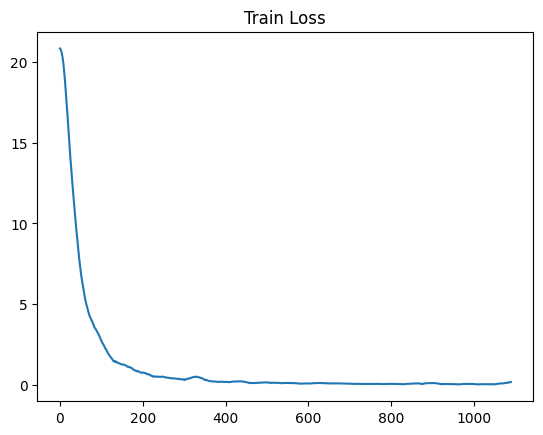

In [38]:
import matplotlib.pyplot as plt

train_losses_10 = [loss*7 for loss in train_evals['loss']]
train_losses_10 = savitzky_golay(train_losses_10, 51, 3)
plt.plot(train_losses_10)
plt.title("Train Loss")
plt.show()

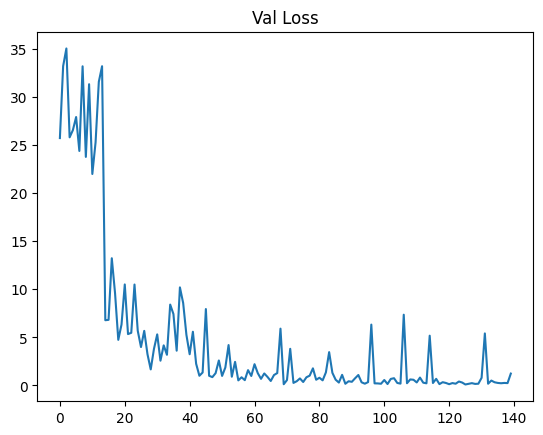

In [39]:
val_losses_10 = [loss*100 for loss in val_evals['loss']]
plt.plot(val_losses_10)
plt.title("Val Loss")
plt.show()

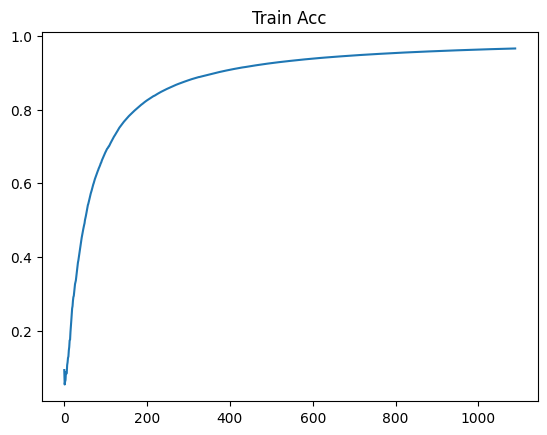

In [40]:
plt.plot(train_evals['acc'])
plt.title("Train Acc")
plt.show()

<ipython-input-37-bf6674856c50>:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  window_size = np.abs(np.int(window_size))
<ipython-input-37-bf6674856c50>:4: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20

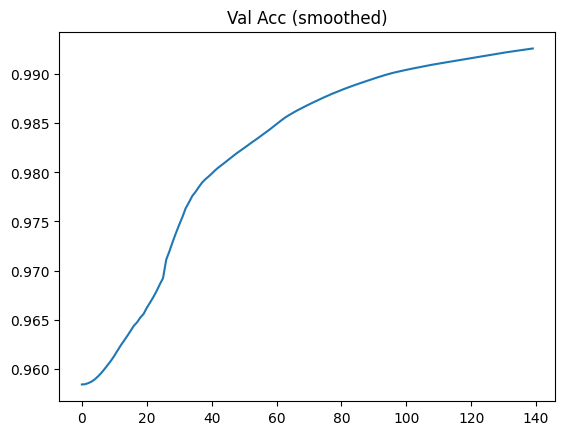

In [41]:
smoothed_val_acc = savitzky_golay(val_evals['acc'], 51, 3)
plt.plot(smoothed_val_acc)
plt.title('Val Acc (smoothed)')
plt.show()

## compare

### efficient net

In [72]:
from torchvision.models import efficientnet_v2_s
from torch import nn, optim

## Efficient Net
model = efficientnet_v2_s(pretrained=True)
model.classifier[1] = nn.Linear(model.classifier[1].in_features, len(train_set.classes))

# Check if GPU is available and move the model to GPU if it is
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Define your loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_V2_S_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_V2_S_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [73]:
training()

100%|██████████| 14/14 [00:04<00:00,  2.89it/s]


Epoch [1/10], Train Loss: 0.5648, Train Acc: 0.7211316227912903, Train F1: 0.7211316227912903
Train Acc per Class: [0.840625   0.82985073 0.6976744  0.74085367 0.80177516 0.68501526
 0.5579937  0.6105919  0.72699386 0.6996997  0.56764704 0.6785714
 0.7903226  0.7529762  0.82831323 0.7469512  0.6048632  0.7687688
 0.71165645 0.70552146 0.7947214 ]

Epoch [1/10], Val Loss 0.0426, Val Acc: 0.9833333492279053, Val F1: 0.9833333492279053



100%|██████████| 14/14 [00:05<00:00,  2.75it/s]


Epoch [2/10], Train Loss: 0.3069, Train Acc: 0.855513870716095, Train F1: 0.855513870716095
Train Acc per Class: [0.91875    0.91343284 0.8386628  0.8597561  0.90088755 0.8394495
 0.7711599  0.7959502  0.85276073 0.8438438  0.77205884 0.8244048
 0.89193547 0.875      0.9141566  0.8719512  0.79635257 0.8843844
 0.85276073 0.851227   0.8958944 ]

Epoch [2/10], Val Loss 0.0117, Val Acc: 0.987500011920929, Val F1: 0.987500011920929



100%|██████████| 14/14 [00:05<00:00,  2.78it/s]


Epoch [3/10], Train Loss: 0.0100, Train Acc: 0.9024730324745178, Train F1: 0.9024730324745178
Train Acc per Class: [0.9458333  0.9422886  0.8914729  0.9054878  0.93392503 0.891947
 0.84535    0.8598131  0.8997955  0.8938939  0.84411764 0.88095236
 0.927957   0.9166667  0.9427711  0.9136179  0.86119556 0.9229229
 0.9018405  0.8997955  0.9296188 ]

Epoch [3/10], Val Loss 0.0081, Val Acc: 0.9908730387687683, Val F1: 0.9908730387687683



100%|██████████| 14/14 [00:04<00:00,  2.88it/s]


Epoch [4/10], Train Loss: 0.0318, Train Acc: 0.9256278872489929, Train F1: 0.9256278872489929
Train Acc per Class: [0.959375   0.95522386 0.9135174  0.9237805  0.9504438  0.9181957
 0.8840125  0.89252335 0.922546   0.9204204  0.8808824  0.9077381
 0.94596773 0.9375     0.95707834 0.9352134  0.89361703 0.9421922
 0.9263804  0.92484665 0.94648093]

Epoch [4/10], Val Loss 0.0030, Val Acc: 0.993154764175415, Val F1: 0.993154764175415



100%|██████████| 14/14 [00:04<00:00,  2.86it/s]


Epoch [5/10], Train Loss: 0.0117, Train Acc: 0.9401270151138306, Train F1: 0.9401270151138306
Train Acc per Class: [0.9675     0.9641791  0.92906976 0.9390244  0.96035504 0.9345566
 0.9059561  0.9140187  0.9380368  0.93453455 0.90411764 0.9255952
 0.9567742  0.95       0.96506023 0.9481707  0.9142857  0.95375377
 0.9411043  0.9398773  0.9565982 ]

Epoch [5/10], Val Loss 0.0019, Val Acc: 0.994523823261261, Val F1: 0.994523823261261



100%|██████████| 14/14 [00:04<00:00,  2.84it/s]


Epoch [6/10], Train Loss: 0.3007, Train Acc: 0.9498412013053894, Train F1: 0.9498412013053894
Train Acc per Class: [0.97291666 0.96965176 0.94089144 0.949187   0.9669625  0.94546384
 0.9190178  0.9283489  0.948364   0.9449449  0.92009807 0.93799603
 0.96397847 0.9583333  0.97088355 0.9568089  0.92755824 0.9614615
 0.9509202  0.9493865  0.9633431 ]

Epoch [6/10], Val Loss 0.0019, Val Acc: 0.995039701461792, Val F1: 0.995039701461792



100%|██████████| 14/14 [00:05<00:00,  2.76it/s]


Epoch [7/10], Train Loss: 0.0403, Train Acc: 0.9565118551254272, Train F1: 0.9565118551254272
Train Acc per Class: [0.9767857  0.97356075 0.9493356  0.956446   0.9716822  0.95238096
 0.92924315 0.93813974 0.95223486 0.95152295 0.93109244 0.9464286
 0.9686636  0.96428573 0.97504306 0.9629791  0.93703866 0.966967
 0.95793164 0.9561788  0.9685798 ]

Epoch [7/10], Val Loss 0.0290, Val Acc: 0.9957482814788818, Val F1: 0.9957482814788818



100%|██████████| 14/14 [00:05<00:00,  2.78it/s]


Epoch [8/10], Train Loss: 0.0801, Train Acc: 0.9616953134536743, Train F1: 0.9616953134536743
Train Acc per Class: [0.9796875  0.97686565 0.9556686  0.9618902  0.9752219  0.9583333
 0.9376959  0.94509345 0.9582055  0.9568318  0.9386029  0.95275295
 0.9725807  0.96875    0.9777861  0.9672256  0.943769   0.9710961
 0.9631902  0.96165645 0.97250736]

Epoch [8/10], Val Loss 0.0008, Val Acc: 0.9961309432983398, Val F1: 0.9961309432983398



100%|██████████| 14/14 [00:04<00:00,  2.87it/s]


Epoch [9/10], Train Loss: 0.0019, Train Acc: 0.9658551216125488, Train F1: 0.9658551216125488
Train Acc per Class: [0.98194444 0.97943616 0.9605943  0.96612465 0.977975   0.962963
 0.9442703  0.95119417 0.9628494  0.9616283  0.94509804 0.95767194
 0.97562724 0.9718915  0.98025435 0.9708672  0.94967914 0.97430766
 0.96693933 0.9659168  0.9755621 ]

Epoch [9/10], Val Loss 0.0007, Val Acc: 0.9962962865829468, Val F1: 0.9962962865829468



100%|██████████| 14/14 [00:04<00:00,  2.83it/s]

Epoch [10/10], Train Loss: 0.0060, Train Acc: 0.9690242409706116, Train F1: 0.9690242409706116
Train Acc per Class: [0.98375    0.9814925  0.9645349  0.9695122  0.9801775  0.96666664
 0.94952977 0.9560748  0.9662577  0.96336335 0.94941175 0.96130955
 0.97806454 0.97440475 0.98222893 0.97347564 0.95471126 0.97687685
 0.9702454  0.9693251  0.9780059 ]

Epoch [10/10], Val Loss 0.0015, Val Acc: 0.9964285492897034, Val F1: 0.9964285492897034



In [56]:
testeval()

100%|██████████| 965/965 [00:27<00:00, 34.79it/s]

Test Loss: 0.0016, Test Acc: 0.9979274868965149, Test F1: 0.9979274868965149


### google net

In [69]:
from torchvision.models import googlenet
from torch import nn, optim

## Efficient Net
model = googlenet(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, len(train_set.classes))

# Check if GPU is available and move the model to GPU if it is
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Define your loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

In [70]:
training()

100%|██████████| 14/14 [00:03<00:00,  4.42it/s]


Epoch [1/10], Train Loss: 0.7294, Train Acc: 0.6522806286811829, Train F1: 0.6522806286811829
Train Acc per Class: [0.8875     0.87761194 0.6686047  0.5365854  0.7751479  0.5535168
 0.5862069  0.37383178 0.79141104 0.44144145 0.5882353  0.6904762
 0.6935484  0.65178573 0.63554215 0.77134144 0.3556231  0.6426426
 0.69631904 0.74846625 0.72727275]

Epoch [1/10], Val Loss 0.6978, Val Acc: 0.9404761791229248, Val F1: 0.9404761791229248



100%|██████████| 14/14 [00:03<00:00,  4.27it/s]


Epoch [2/10], Train Loss: 0.1418, Train Acc: 0.8101905584335327, Train F1: 0.8101905584335327
Train Acc per Class: [0.9421875  0.92985076 0.809593   0.72865856 0.88757396 0.7691131
 0.7680251  0.6542056  0.83435583 0.7072072  0.7632353  0.8154762
 0.83709675 0.82589287 0.81626505 0.87957317 0.65957445 0.8123123
 0.8389571  0.87116563 0.8607038 ]

Epoch [2/10], Val Loss 0.0591, Val Acc: 0.961904764175415, Val F1: 0.961904764175415



100%|██████████| 14/14 [00:03<00:00,  4.06it/s]


Epoch [3/10], Train Loss: 0.1463, Train Acc: 0.8706697225570679, Train F1: 0.8706697225570679
Train Acc per Class: [0.9614583  0.95124376 0.86724806 0.8109756  0.9250493  0.8440367
 0.8411703  0.76323986 0.8834356  0.7987988  0.8372549  0.8730159
 0.89032257 0.8839286  0.87650603 0.91971546 0.7710233  0.8748749
 0.88957053 0.9141104  0.9051808 ]

Epoch [3/10], Val Loss 0.0263, Val Acc: 0.9734126925468445, Val F1: 0.9734126925468445



100%|██████████| 14/14 [00:03<00:00,  4.21it/s]


Epoch [4/10], Train Loss: 0.0478, Train Acc: 0.9017754197120667, Train F1: 0.9017754197120667
Train Acc per Class: [0.9703125  0.96268654 0.8989826  0.85670733 0.943787   0.88073397
 0.87931037 0.8185358  0.90720856 0.8468468  0.8757353  0.9025298
 0.91774195 0.9129464  0.9073795  0.9397866  0.8275076  0.9061562
 0.9171779  0.9355828  0.9281525 ]

Epoch [4/10], Val Loss 0.0788, Val Acc: 0.9788690209388733, Val F1: 0.9788690209388733



100%|██████████| 14/14 [00:03<00:00,  4.54it/s]


Epoch [5/10], Train Loss: 0.0503, Train Acc: 0.9206120371818542, Train F1: 0.9206120371818542
Train Acc per Class: [0.97625    0.9701493  0.91918606 0.8847561  0.95443785 0.90397555
 0.9028213  0.85046726 0.9220859  0.87747747 0.8976471  0.9190476
 0.93419355 0.93035716 0.9259036  0.95182925 0.86139816 0.9249249
 0.93374234 0.94846624 0.942522  ]

Epoch [5/10], Val Loss 0.0109, Val Acc: 0.9828571677207947, Val F1: 0.9828571677207947



100%|██████████| 14/14 [00:03<00:00,  4.49it/s]


Epoch [6/10], Train Loss: 0.0264, Train Acc: 0.9336990118026733, Train F1: 0.9336990118026733
Train Acc per Class: [0.98020834 0.97512436 0.93168604 0.90345526 0.96203154 0.91997963
 0.9190178  0.8748702  0.9350716  0.8973974  0.9147059  0.9325397
 0.9451613  0.94196427 0.938253   0.9598577  0.8839919  0.9374374
 0.9447853  0.9570552  0.95210165]

Epoch [6/10], Val Loss 0.0039, Val Acc: 0.9857142567634583, Val F1: 0.9857142567634583



100%|██████████| 14/14 [00:03<00:00,  4.60it/s]


Epoch [7/10], Train Loss: 0.0188, Train Acc: 0.943129301071167, Train F1: 0.943129301071167
Train Acc per Class: [0.98303574 0.97867805 0.9414452  0.9168118  0.9674556  0.9314111
 0.93058664 0.8927459  0.9443471  0.9120549  0.92689073 0.9421769
 0.9529954  0.9502551  0.947074   0.9655923  0.9001303  0.94637495
 0.9526731  0.9631902  0.95894426]

Epoch [7/10], Val Loss 0.0037, Val Acc: 0.9877551198005676, Val F1: 0.9877551198005676



100%|██████████| 14/14 [00:03<00:00,  4.53it/s]


Epoch [8/10], Train Loss: 0.0167, Train Acc: 0.9502201080322266, Train F1: 0.9502201080322266
Train Acc per Class: [0.98515624 0.98134327 0.94876456 0.9272104  0.97152364 0.93998474
 0.93926334 0.90615267 0.95130366 0.923048   0.93602943 0.9494048
 0.95887095 0.95647323 0.95368975 0.9698933  0.91223407 0.9530781
 0.95858896 0.96779144 0.9640762 ]

Epoch [8/10], Val Loss 0.0032, Val Acc: 0.9892857074737549, Val F1: 0.9892857074737549



100%|██████████| 14/14 [00:03<00:00,  4.35it/s]


Epoch [9/10], Train Loss: 0.0140, Train Acc: 0.9556229114532471, Train F1: 0.9556229114532471
Train Acc per Class: [0.98680556 0.98341626 0.95445734 0.9352981  0.9746877  0.94665307
 0.94601184 0.9155417  0.9556919  0.93159825 0.9431372  0.95502645
 0.96308243 0.96130955 0.95883536 0.97323847 0.9216481  0.95829165
 0.9631902  0.97137016 0.96806777]

Epoch [9/10], Val Loss 0.0038, Val Acc: 0.9900793433189392, Val F1: 0.9900793433189392



100%|██████████| 14/14 [00:03<00:00,  4.11it/s]

Epoch [10/10], Train Loss: 0.0147, Train Acc: 0.9599595665931702, Train F1: 0.9599595665931702
Train Acc per Class: [0.988125   0.98507464 0.9590116  0.9417683  0.9772189  0.951682
 0.95078367 0.92398757 0.959816   0.9384384  0.9488235  0.9592262
 0.96677417 0.96517855 0.9626506  0.97591466 0.9291793  0.9624625
 0.96687114 0.97423315 0.971261  ]

Epoch [10/10], Val Loss 0.0030, Val Acc: 0.9910714030265808, Val F1: 0.9910714030265808



In [71]:
testeval()

100%|██████████| 965/965 [00:12<00:00, 76.65it/s]

Test Loss: 0.0008, Test Acc: 0.9979274868965149, Test F1: 0.9979274868965149


In [ ]:
torch.cuda.empty_cache()

## save model

In [ ]:
EPOCH = 4
PATH = "mobilenet_clf.pt"
LOSS = 0.4

torch.save({
            'epoch': EPOCH,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            }, PATH)

In [ ]:
model.eval()
with torch.no_grad():
    for images, labels in testloader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        acc = metric(outputs, labels)
        print(acc)

## inference

In [ ]:
# sample execution (requires torchvision)
from PIL import Image
from torchvision import transforms
input_image = Image.open("/content/testing.jpg")
input_tensor = test_transform(input_image)
input_batch = input_tensor.unsqueeze(0) # create a mini-batch as expected by the model

# move the input and model to GPU for speed if available
if torch.cuda.is_available():
    input_batch = input_batch.to('cuda')
    model.to('cuda')

with torch.no_grad():
    output = model(input_batch)
# Tensor of shape 1000, with confidence scores over ImageNet's 1000 classes
print(output[0])
# The output has unnormalized scores. To get probabilities, you can run a softmax on it.
probabilities = torch.nn.functional.softmax(output[0], dim=0)
print(np.argmax(probabilities.cpu()))

tensor([-0.4926, -2.2442, -1.1558, -0.1711, -0.3946,  1.3575, -1.4911, -1.8864,
        -1.4768, -2.3122, -2.1280, -2.2473,  1.7768,  0.1371, -1.9116, -1.1115,
        -0.4552,  4.6893,  0.7082, -0.8215, -0.3796], device='cuda:0')
tensor(17)
